In [1]:
import sys
sys.path.append('../')

import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from hhar_data import complex_pattern, gen_prim_dataset, IMUDataset
from utils import set_seed

In [2]:
# Device set-up

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")
    
print(device)

cuda:0


In [3]:
seed = 0
set_seed(seed) # set random seed

# Load the pre-processed HHAR dataset as primitve activities

The HHAR dataset contains the readings of two motion sensors while users executed activities carrying smartwatches and smartphones.  
>Activities: ‘Biking’, ‘Sitting’, ‘Standing’, ‘Walking’, ‘Stair Up’ and ‘Stair down’    
Sensors: Sensors: Two embedded sensors, i.e., Accelerometer and Gyroscope, sampled at the highest frequency the respective device allows.  
Devices: 4 smartwatches (2 LG watches, 2 Samsung Galaxy Gears), 8 smartphones (2 Samsung Galaxy S3 mini, 2 Samsung Galaxy S3, 2 LG Nexus 4, 2 Samsung Galaxy S+).  
Recordings: 9 users. 

We will use a preprocessed version contributed by https://github.com/dapowan/LIMU-BERT-Public/tree/master/dataset, and only select four activities to use.

## Data loading
Select four activities and generate primitive activity dataset using `gen_prim_dataset` function. Load the dataset using `IMUDataset` defined in `hhar_data.py`.

In [4]:
# Select four activities

class_dict = {0: "Biking", 1: "Sitting", 2: "Standing", 3: "Walking", 4: "Stair Up", 5: "Stair down"}
labels = [0, 1, 3, 4]
prim_class_names = [class_dict[l] for l in labels]
n_atom_class = len(labels)

prim_datasets = gen_prim_dataset(labels)
x_prim_train, y_prim_train = np.load("./hhar_data/train.pkl",allow_pickle=True)
x_prim_test, y_prim_test = np.load("./hhar_data/test.pkl",allow_pickle=True)

In [5]:
# sanity check
x_prim_train.shape, y_prim_train.shape

((4824, 6, 120), (4824,))

In [6]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5), (0.5)),
                                ])

In [7]:
primitive_train_data = IMUDataset(x_prim_train, y_prim_train, transforms=transform)
primitive_test_data = IMUDataset(x_prim_test, y_prim_test, transforms=transform)

primitive_train_kwargs = {'batch_size': 256, 'shuffle': True}
primitive_train_loader = DataLoader(primitive_train_data, **primitive_train_kwargs)

primitive_test_kwargs = {'batch_size': 256, 'shuffle': False}
primitive_test_loader = DataLoader(primitive_test_data, **primitive_test_kwargs)

## Train a classifier using direct supervision
Test the dataset and the neural network models by running a classic training pipeline using direct supervison. (This part can be skipped)

In [8]:
from models import CNN1D
from utils import plot_confusion_matrix, prim_test, prim_train, PlotHelper

Epoch: 0
Accuracy of the network on the test data: 77 %
Accuracy of activity  0 : 82 %
Accuracy of activity  1 : 71 %
Accuracy of activity  2 : 70 %
Accuracy of activity  3 : 89 %
Epoch: 1
Accuracy of the network on the test data: 85 %
Accuracy of activity  0 : 75 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 86 %
Accuracy of activity  3 : 94 %
Epoch: 2
Accuracy of the network on the test data: 89 %
Accuracy of activity  0 : 75 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 95 %
Accuracy of activity  3 : 94 %
Epoch: 3
Accuracy of the network on the test data: 91 %
Accuracy of activity  0 : 76 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 90 %
Epoch: 4
Accuracy of the network on the test data: 92 %
Accuracy of activity  0 : 79 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %
Epoch: 5
Accuracy of the network on the test data: 94 %
Accuracy of activity  0 : 85 %
Accuracy of

/home/nesl/Documents/PYLON-CE-examples/CE-IMU-examples/../utils.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


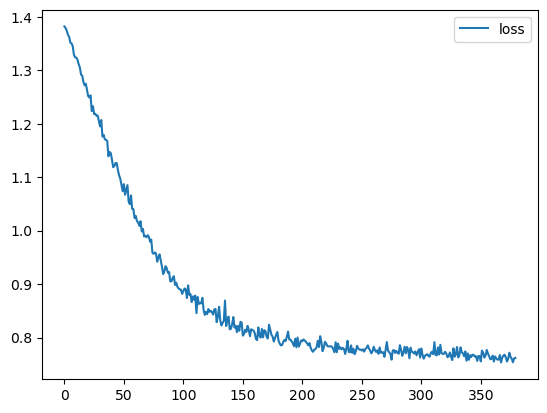

In [9]:
cnn_model = CNN1D(n_atom_class, drop_out=0.0)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)
prim_train(cnn_model, primitive_train_loader,primitive_test_loader, optimizer, 20, device=device)

Accuracy of the network on the test data: 99 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 100 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 98 %


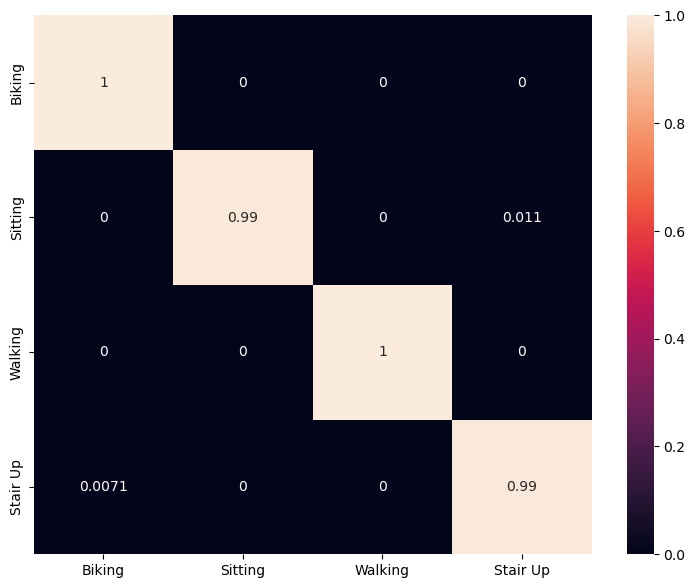

In [10]:
y_true, y_pred, _ = prim_test(cnn_model, primitive_test_loader)
plot_confusion_matrix(y_true, y_pred, prim_class_names)

# Supervise activity classifier w/ complex event labels using PYLON
In this part, we will first generate a complex event dataset according to predifined FSM rules, and then define PYLON constraints for trianing using distant (high-level) complex event label.

We define three complex event classes:
>Complete Care ($e_0$): Night time user response happens before Morning care (primitive activity 1 happens before 3).  
Unhygienic Process ($e_1$): Excretion assistance happens before Meal/medication (primitive activity 0 happens before 2).  
Default Complex Event ($e_2$): Any event that does not satisify previous event patterns.

Corresponding FSMs are defined in `fsm.py`. To see details of the complex event dataset, check `complex_pattern` function in `hhar_data.py`.

## Generate complex event dataset for PYLON training


In [11]:
# Generate complex event training/test set using prmitive activities

from fsm import Event0, Event1

fsm_list = [Event0(), Event1()]
event_class_names = ["Event 0", "Event 1", "No events"]
n_event_class = len(fsm_list) + 1

'''    
Generate a complex event dataset:
    event 0 means "primitive activity 1 happens before 3", 
    event 1 means "primitive activity 0 happens before 2",
    event 2 means "no events: no interesting events occur".
'''
arity = 3
event_train_data = complex_pattern(n=arity, dataset="train", prim_datasets=prim_datasets, fsm_list=fsm_list, seed=seed)
event_test_data = complex_pattern(n=arity, dataset="test", prim_datasets=prim_datasets, fsm_list=fsm_list, seed=seed)

In [12]:
event_train_kwargs = {'batch_size': 64}
event_train_loader = DataLoader(event_train_data, **event_train_kwargs)

event_test_kwargs = {'batch_size': 64
                     }
event_test_loader = DataLoader(event_test_data, **event_test_kwargs)

In [13]:
next(iter(event_test_loader))[3].shape

torch.Size([64])

## Define PYLON constraints for complex events
We use the previous FSMs as constraints

In [14]:
'''Define constraint function and Pylon constraint loss'''

from pylon.constraint import constraint
from pylon.brute_force_solver import SatisfactionBruteForceSolver
# from pylon.brute_force_solver import *

def complex_event(*logits_sequence, **kwargs):
    '''
    logits_sequence: a sequence of logits tensors returned by the primitive classifier
    kwargs['event_label']: ground truth complex event label
    kwargs['event_fsm']: a list of finite state machines for corresponding complex event class
    kwargs['n_event_class]: the number of complex event classes
    '''
    pred_labels = []
    logits_sequence_batch = torch.stack(logits_sequence,-1)
    
    for seq in logits_sequence_batch: # process sequentially in the batch
        pred_label = kwargs['n_event_class'] - 1
        for fsm in kwargs['event_fsm']:
            if fsm.check(seq) == True: # (torch,torch,torch) == (int,int,int) in pylon constraints
                pred_label = fsm.label
        pred_labels.append(torch.tensor(pred_label))
    
    pred_labels = torch.stack(pred_labels)

    return pred_labels == kwargs['event_label']

complex_event_cons = constraint(complex_event)

## Training and Evaluation

In [15]:
# Define train/test functions

def pylon_train(model, n_epoch, optimizer, n_print=100, device='cpu'):
    plot_loss = PlotHelper()
    for epoch in range(n_epoch):
        print("Epoch:", epoch)
        
        # train
        for i, (i1, i2, i3, label) in enumerate(tqdm(event_train_loader)):
            model.train()
            model.to(device)
            optimizer.zero_grad()
            # print(len(x_event_train))
            i1, i2, i3, label = i1.to(device), i2.to(device), i3.to(device), label.to(device)
            output1 = model(i1)
            output2 = model(i2)
            output3 = model(i3)
            
            pred1 = output1.argmax(dim=1, keepdim=False)
            pred2 = output2.argmax(dim=1, keepdim=False)
            pred3 = output3.argmax(dim=1, keepdim=False)
            
            closs = complex_event_cons(output1.cpu(), output2.cpu(), output3.cpu(), event_label=label.cpu(), event_fsm=fsm_list, n_event_class=n_event_class)
            dampner = closs.detach().cpu()
            plot_loss.add(closs = dampner)

            closs.backward()
            optimizer.step()

            if i % n_print == 0:
                prim_test(model, primitive_test_loader)
            
    plot_loss.show()

In [16]:
def event_test(model, cm=False):
    model.eval()
    model.to('cpu')
    correct = 0
    correct_class = [[] for _ in range(n_event_class)]
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for i1, i2, i3, label in event_test_loader:

            output1 = model(i1)
            output2 = model(i2)
            output3 = model(i3)
            
            pred1 = output1.argmax(dim=1, keepdim=False)  # get the index of the max log-probability
            pred2 = output2.argmax(dim=1, keepdim=False)  
            pred3 = output3.argmax(dim=1, keepdim=False)

            pred_label = n_event_class - 1
            for e in fsm_list:
                if e.check([pred1, pred2, pred3]) is True:
                    pred_label = e.label
                    break

            correct += (pred_label == label).sum().item()

            y_true.extend(label.data.cpu().numpy())
            y_pred.extend(np.array([pred_label]))
            
    if cm:
        plot_confusion_matrix(y_true, y_pred, event_class_names)
    
    print('Test set: Overall Complex Event Accuracy: {}/{} ({:.0f}%)\n\
          Complex Event 0 Accuracy: {}/{} ({:.0f}%)\n\
          Complex Event 1 Accuracy: {}/{} ({:.0f}%)\n\
          Complex Event 2 Accuracy: {}/{} ({:.0f}%)\n'
          .format(correct, len(event_test_loader),
                  100. * correct / len(event_test_loader),
                  sum(correct_class[0]), len(correct_class[0]),
                  100. * sum(correct_class[0]) / len(correct_class[0]),
                  sum(correct_class[1]), len(correct_class[1]),
                  100. * sum(correct_class[1]) / len(correct_class[1]),
                  sum(correct_class[2]), len(correct_class[2]),
                  100. * sum(correct_class[2]) / len(correct_class[2])))

In [17]:
from models import CNN1D
from utils import plot_confusion_matrix, prim_test, prim_train, PlotHelper

In [18]:
cnn_model = CNN1D(n_atom_class, drop_out=0.0)
_,_,_ = prim_test(cnn_model, primitive_test_loader)

Accuracy of the network on the test data: 24 %
Accuracy of activity  0 : 10 %
Accuracy of activity  1 :  0 %
Accuracy of activity  2 :  0 %
Accuracy of activity  3 : 95 %


Epoch: 0


  0%|          | 0/26 [00:00<?, ?it/s]/home/nesl/Documents/PYLON-CE-examples/CE-IMU-examples/../pylon/brute_force_solver.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.tensor(data=self.cond(*sample,**kwargs), dtype=torch.bool) for sample in samples ])
  4%|▍         | 1/26 [00:00<00:03,  6.79it/s]

Accuracy of the network on the test data: 34 %
Accuracy of activity  0 : 74 %
Accuracy of activity  1 :  0 %
Accuracy of activity  2 :  0 %
Accuracy of activity  3 : 78 %


100%|██████████| 26/26 [00:02<00:00,  8.74it/s]


Epoch: 1


  4%|▍         | 1/26 [00:00<00:03,  6.53it/s]

Accuracy of the network on the test data: 92 %
Accuracy of activity  0 : 80 %
Accuracy of activity  1 : 95 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  8.68it/s]


Epoch: 2


  4%|▍         | 1/26 [00:00<00:04,  5.48it/s]

Accuracy of the network on the test data: 94 %
Accuracy of activity  0 : 94 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 97 %
Accuracy of activity  3 : 89 %


100%|██████████| 26/26 [00:03<00:00,  8.60it/s]


Epoch: 3


  4%|▍         | 1/26 [00:00<00:03,  6.73it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 94 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch: 4


  4%|▍         | 1/26 [00:00<00:03,  6.33it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 91 %


100%|██████████| 26/26 [00:02<00:00,  8.95it/s]


Epoch: 5


  4%|▍         | 1/26 [00:00<00:03,  6.77it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  8.99it/s]


Epoch: 6


  4%|▍         | 1/26 [00:00<00:04,  5.91it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 95 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  8.95it/s]


Epoch: 7


  4%|▍         | 1/26 [00:00<00:03,  7.07it/s]

Accuracy of the network on the test data: 95 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.35it/s]


Epoch: 8


  4%|▍         | 1/26 [00:00<00:03,  7.24it/s]

Accuracy of the network on the test data: 95 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.37it/s]


Epoch: 9


  4%|▍         | 1/26 [00:00<00:03,  6.98it/s]

Accuracy of the network on the test data: 95 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.14it/s]


Epoch: 10


  4%|▍         | 1/26 [00:00<00:03,  6.86it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 98 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 89 %


100%|██████████| 26/26 [00:02<00:00,  9.41it/s]


Epoch: 11


  4%|▍         | 1/26 [00:00<00:03,  7.07it/s]

Accuracy of the network on the test data: 94 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 87 %
Accuracy of activity  2 : 99 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.21it/s]


Epoch: 12


  4%|▍         | 1/26 [00:00<00:04,  6.16it/s]

Accuracy of the network on the test data: 95 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.26it/s]


Epoch: 13


  4%|▍         | 1/26 [00:00<00:03,  6.94it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 97 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 91 %


100%|██████████| 26/26 [00:02<00:00,  9.33it/s]


Epoch: 14


  4%|▍         | 1/26 [00:00<00:03,  7.21it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.26it/s]


Epoch: 15


  4%|▍         | 1/26 [00:00<00:04,  6.21it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.33it/s]


Epoch: 16


  4%|▍         | 1/26 [00:00<00:03,  7.11it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 94 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.14it/s]


Epoch: 17


  4%|▍         | 1/26 [00:00<00:03,  6.95it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 99 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.16it/s]


Epoch: 18


  4%|▍         | 1/26 [00:00<00:03,  7.15it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 93 %


100%|██████████| 26/26 [00:02<00:00,  9.24it/s]


Epoch: 19


  4%|▍         | 1/26 [00:00<00:03,  7.13it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 100 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 90 %


100%|██████████| 26/26 [00:02<00:00,  9.14it/s]


Epoch: 20


  4%|▍         | 1/26 [00:00<00:03,  7.00it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 99 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.14it/s]


Epoch: 21


  4%|▍         | 1/26 [00:00<00:03,  7.12it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.32it/s]


Epoch: 22


  4%|▍         | 1/26 [00:00<00:03,  7.05it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.15it/s]


Epoch: 23


  4%|▍         | 1/26 [00:00<00:03,  6.96it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.14it/s]


Epoch: 24


  4%|▍         | 1/26 [00:00<00:03,  6.31it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.17it/s]


Epoch: 25


  4%|▍         | 1/26 [00:00<00:03,  6.82it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.13it/s]


Epoch: 26


  4%|▍         | 1/26 [00:00<00:03,  6.77it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.18it/s]


Epoch: 27


  4%|▍         | 1/26 [00:00<00:03,  7.14it/s]

Accuracy of the network on the test data: 95 %
Accuracy of activity  0 : 97 %
Accuracy of activity  1 : 99 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 83 %


100%|██████████| 26/26 [00:02<00:00,  9.29it/s]


Epoch: 28


  4%|▍         | 1/26 [00:00<00:03,  7.11it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 97 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.36it/s]


Epoch: 29


  4%|▍         | 1/26 [00:00<00:03,  7.08it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 98 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.35it/s]


Epoch: 30


  4%|▍         | 1/26 [00:00<00:03,  7.00it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.27it/s]


Epoch: 31


  4%|▍         | 1/26 [00:00<00:03,  6.94it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.24it/s]


Epoch: 32


  4%|▍         | 1/26 [00:00<00:03,  6.73it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.13it/s]


Epoch: 33


  4%|▍         | 1/26 [00:00<00:03,  6.98it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 96 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.07it/s]


Epoch: 34


  4%|▍         | 1/26 [00:00<00:03,  7.00it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 93 %


100%|██████████| 26/26 [00:02<00:00,  9.25it/s]


Epoch: 35


  4%|▍         | 1/26 [00:00<00:03,  6.37it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.11it/s]


Epoch: 36


  4%|▍         | 1/26 [00:00<00:03,  7.19it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.20it/s]


Epoch: 37


  4%|▍         | 1/26 [00:00<00:03,  7.14it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.19it/s]


Epoch: 38


  4%|▍         | 1/26 [00:00<00:04,  5.96it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  8.96it/s]


Epoch: 39


  4%|▍         | 1/26 [00:00<00:03,  6.65it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  9.27it/s]
/home/nesl/Documents/PYLON-CE-examples/CE-IMU-examples/../utils.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


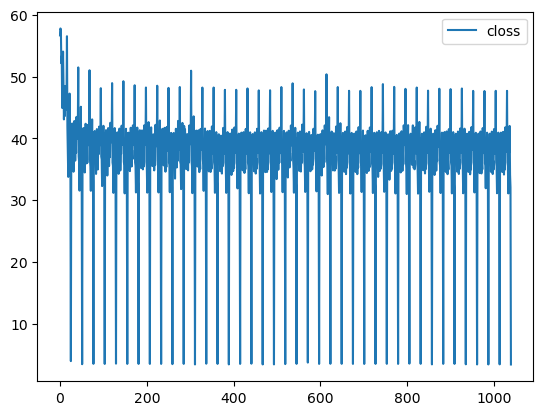

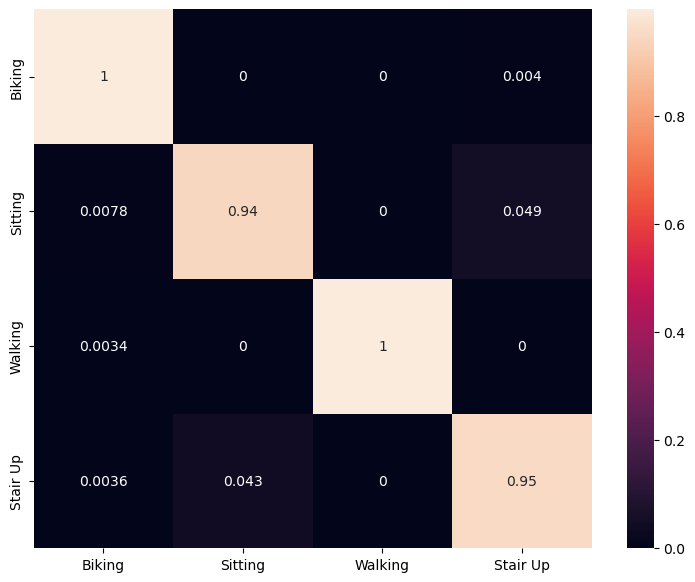

In [19]:
optimizer_pylon = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
pylon_train(cnn_model, 40, optimizer_pylon)
y_true, y_pred, _ = prim_test(cnn_model, primitive_test_loader)
plot_confusion_matrix(y_true, y_pred, prim_class_names)

## Train with a warm-up
In this setting, we train the activity classifier with direct supervision for a few epochs, and then switch to PYLON for distant-supervised training.

Epoch: 0
Accuracy of the network on the test data: 81 %
Accuracy of activity  0 : 33 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %
Epoch: 1
Accuracy of the network on the test data: 93 %
Accuracy of activity  0 : 79 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %
Epoch: 2
Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 100 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %
Epoch: 3
Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 95 %
Accuracy of activity  1 : 100 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %
Epoch: 4
Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 97 %
Accuracy of activity  1 : 100 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 88 %
Epoch: 5
Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accur

/home/nesl/Documents/PYLON-CE-examples/CE-IMU-examples/../utils.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


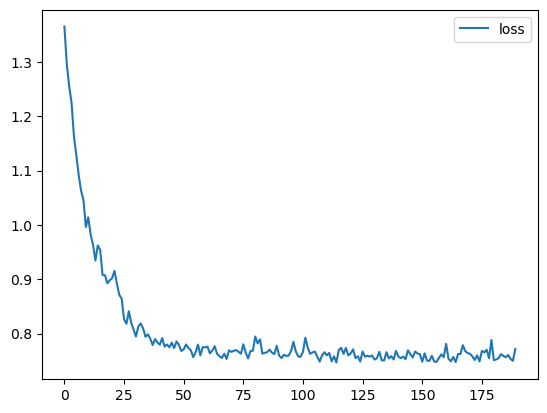

In [20]:
cnn_model = CNN1D(n_atom_class, drop_out=0.0)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
prim_train(cnn_model, primitive_train_loader,primitive_test_loader, optimizer, 10)
_,_,_ = prim_test(cnn_model, primitive_test_loader)

Epoch: 0


  0%|          | 0/26 [00:00<?, ?it/s]/home/nesl/Documents/PYLON-CE-examples/CE-IMU-examples/../pylon/brute_force_solver.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.tensor(data=self.cond(*sample,**kwargs), dtype=torch.bool) for sample in samples ])
  4%|▍         | 1/26 [00:00<00:03,  6.65it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 100 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 85 %


100%|██████████| 26/26 [00:02<00:00,  9.10it/s]


Epoch: 1


  4%|▍         | 1/26 [00:00<00:03,  6.83it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 97 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 98 %


100%|██████████| 26/26 [00:02<00:00,  9.11it/s]


Epoch: 2


  4%|▍         | 1/26 [00:00<00:03,  6.63it/s]

Accuracy of the network on the test data: 98 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 98 %


100%|██████████| 26/26 [00:02<00:00,  9.06it/s]


Epoch: 3


  4%|▍         | 1/26 [00:00<00:03,  6.58it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 94 %
Accuracy of activity  2 : 99 %
Accuracy of activity  3 : 98 %


100%|██████████| 26/26 [00:02<00:00,  9.13it/s]


Epoch: 4


  4%|▍         | 1/26 [00:00<00:03,  6.62it/s]

Accuracy of the network on the test data: 95 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 97 %


100%|██████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch: 5


  4%|▍         | 1/26 [00:00<00:03,  6.85it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 94 %


100%|██████████| 26/26 [00:02<00:00,  9.19it/s]


Epoch: 6


  4%|▍         | 1/26 [00:00<00:04,  6.04it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 93 %


100%|██████████| 26/26 [00:02<00:00,  8.75it/s]


Epoch: 7


  4%|▍         | 1/26 [00:00<00:04,  5.72it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 97 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  8.90it/s]


Epoch: 8


  4%|▍         | 1/26 [00:00<00:04,  6.17it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 100 %
Accuracy of activity  1 : 97 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 92 %


100%|██████████| 26/26 [00:02<00:00,  8.95it/s]


Epoch: 9


  4%|▍         | 1/26 [00:00<00:03,  6.98it/s]

Accuracy of the network on the test data: 96 %
Accuracy of activity  0 : 93 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 96 %


100%|██████████| 26/26 [00:02<00:00,  9.28it/s]


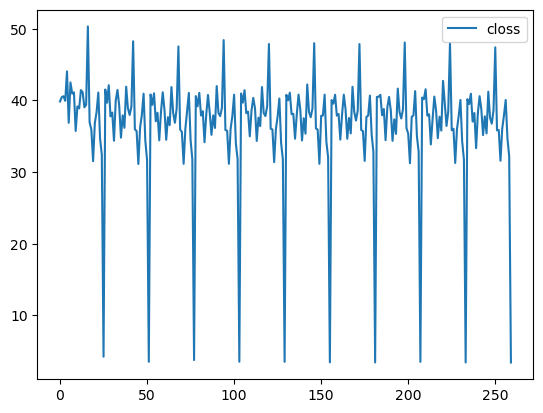

In [21]:
optimizer_pylon = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
pylon_train(cnn_model, 10, optimizer_pylon)

Accuracy of the network on the test data: 98 %
Accuracy of activity  0 : 99 %
Accuracy of activity  1 : 96 %
Accuracy of activity  2 : 100 %
Accuracy of activity  3 : 98 %


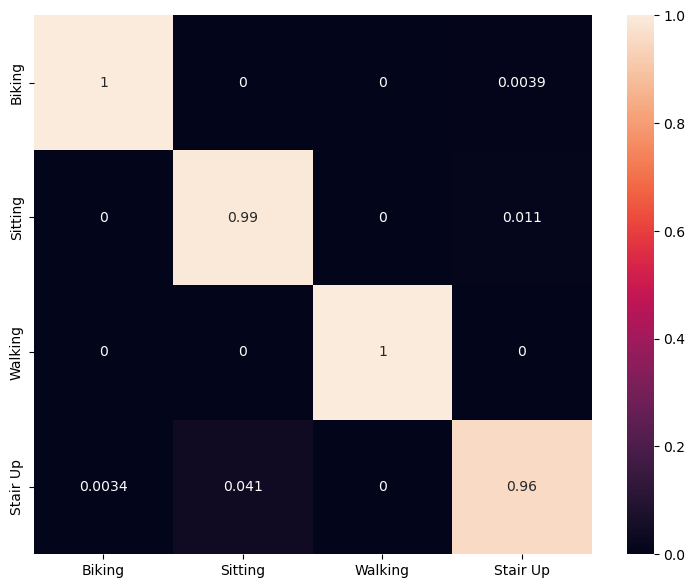

In [22]:
y_true, y_pred, _ = prim_test(cnn_model, primitive_test_loader)
plot_confusion_matrix(y_true, y_pred, prim_class_names)